# Import dependencies and libraries

In [3]:
import os
import json
import pickle as pickle

import geopandas as gpd
import pandas as pd
import numpy as np

# for fitting empirical distributions for radius of gyration and jump length
import powerlaw

# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# trackintel -> the functions will be imported with full names
import trackintel as ti


In [4]:
# options for better printing and visualizing

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

In [5]:
# get the data dir from the config file -> default stored in Data/Geolife/Data folder

DATA_DIR = os.path.join("..", "paths.json")
with open(DATA_DIR) as json_file:
    CONFIG = json.load(json_file)

save_dir = os.path.join("..", CONFIG["data_dir"])

# Load Geolife data
Trackintel provides a function [read_geolife](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_geolife) to directly load [Geolife](https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/) dataset into the trackintel positionfixes. For the tutorial and interactive section, we provided you a sample dataset with 20 selected users from the geolife dataset. This can be directly loaded from the `save_dir`. 

In [6]:

pfs, mode_labels = ti.io.read_geolife(save_dir, print_progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


## Reading your own data
Trackintel provides an I/O module for accessing movement data and storing intermediate or final results in a file or database. Three methods for converting movement data with attached attribute information to Trackintel-compatible formats are provided:
1) reading from Pandas Dataframes and Geopandas Geodataframes (**recommended**)
2) reading and writing from CSV file formats
3) reading and storing from PostgreSQL databases with PostGIS extension. Check the [input/output](https://trackintel.readthedocs.io/en/latest/modules/io.html) module for more information. 

An important consideration before loading data is to find the appropriate movement level for your data. Depending on the semantics of the data, you should call different reading functions, e.g., [read_positionfixes_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_positionfixes_csv) or [read_staypoints_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_staypoints_csv). We provide a reference of the different data types in the figure below:

![Trackintel data support](prepare/trackintel_structure.png)

In [5]:
# TODO: use ti.read_positionfixes_csv() or ti.read_staypoints_csv() for loading your data. Check the documentation for the required input parameters
# pfs = ti.read_positionfixes_csv()

# Calculate radius of gyration

Radius of gyration calculates the characteristic distance traveled by individuals from a set of stop points, which corresponds to the staypoint data model in trackintel. The first step is thus to generate the staypoints from the original positionfixes with the trackintel [generate_staypoints](https://trackintel.readthedocs.io/en/latest/modules/preprocessing.html#trackintel.preprocessing.generate_staypoints) function.

## Generate staypoints

In [7]:
# TODO: Generate staypoints from positionfixes with generate_staypoints() function, check and specify the parameters
pfs, sp = pfs.generate_staypoints(...)


sp["duration"] = (sp["finished_at"] - sp["started_at"])

/Users/yehong/mambaforge/envs/reprotrack/lib/python3.9/site-packages/trackintel/preprocessing/positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


## Calculate radius of gyration with trackintel functions
Trackintel provides the function [ti.analysis.radius_gyration](https://trackintel.readthedocs.io/en/latest/modules/analysis.html#trackintel.analysis.radius_gyration) to calculate user level radius of gyration from staypoints. The function supports weighting the staypoints with their stayed duration during calculation, such that important locations (i.e., locations stayed longer; home or work) receive higher weights.

In [10]:
# TODO: use radius_gyration() function that accepts the generated staypoints
rg_count = ti.analysis.radius_gyration(...)

rg_duration = ti.analysis.radius_gyration(...)

In [12]:
# check the results
rg_duration

user_id
1        2555.886949
2      141198.752644
7       13553.414520
9        1018.344049
11       4754.886298
12     186413.225495
14       8555.789344
16       7210.718648
19       6092.686357
20       1654.699671
22     279212.826582
30      25388.192564
35       2341.146492
39      17311.886386
41      28546.339318
103     15555.883922
112      3547.498514
113      5115.375339
154     55885.293697
169      5419.747608
Name: radius_gyration, dtype: float64

## Visualize with powerlaw package
The [powerlaw](https://github.com/jeffalstott/powerlaw) package provides functionalities to fit power-law, truncated power law, and log normal distributions to the original data. It also provides functionalities to plot all the fitted distributions on the same plot. We use the powerlaw package to visualize the radius of calculation result. 

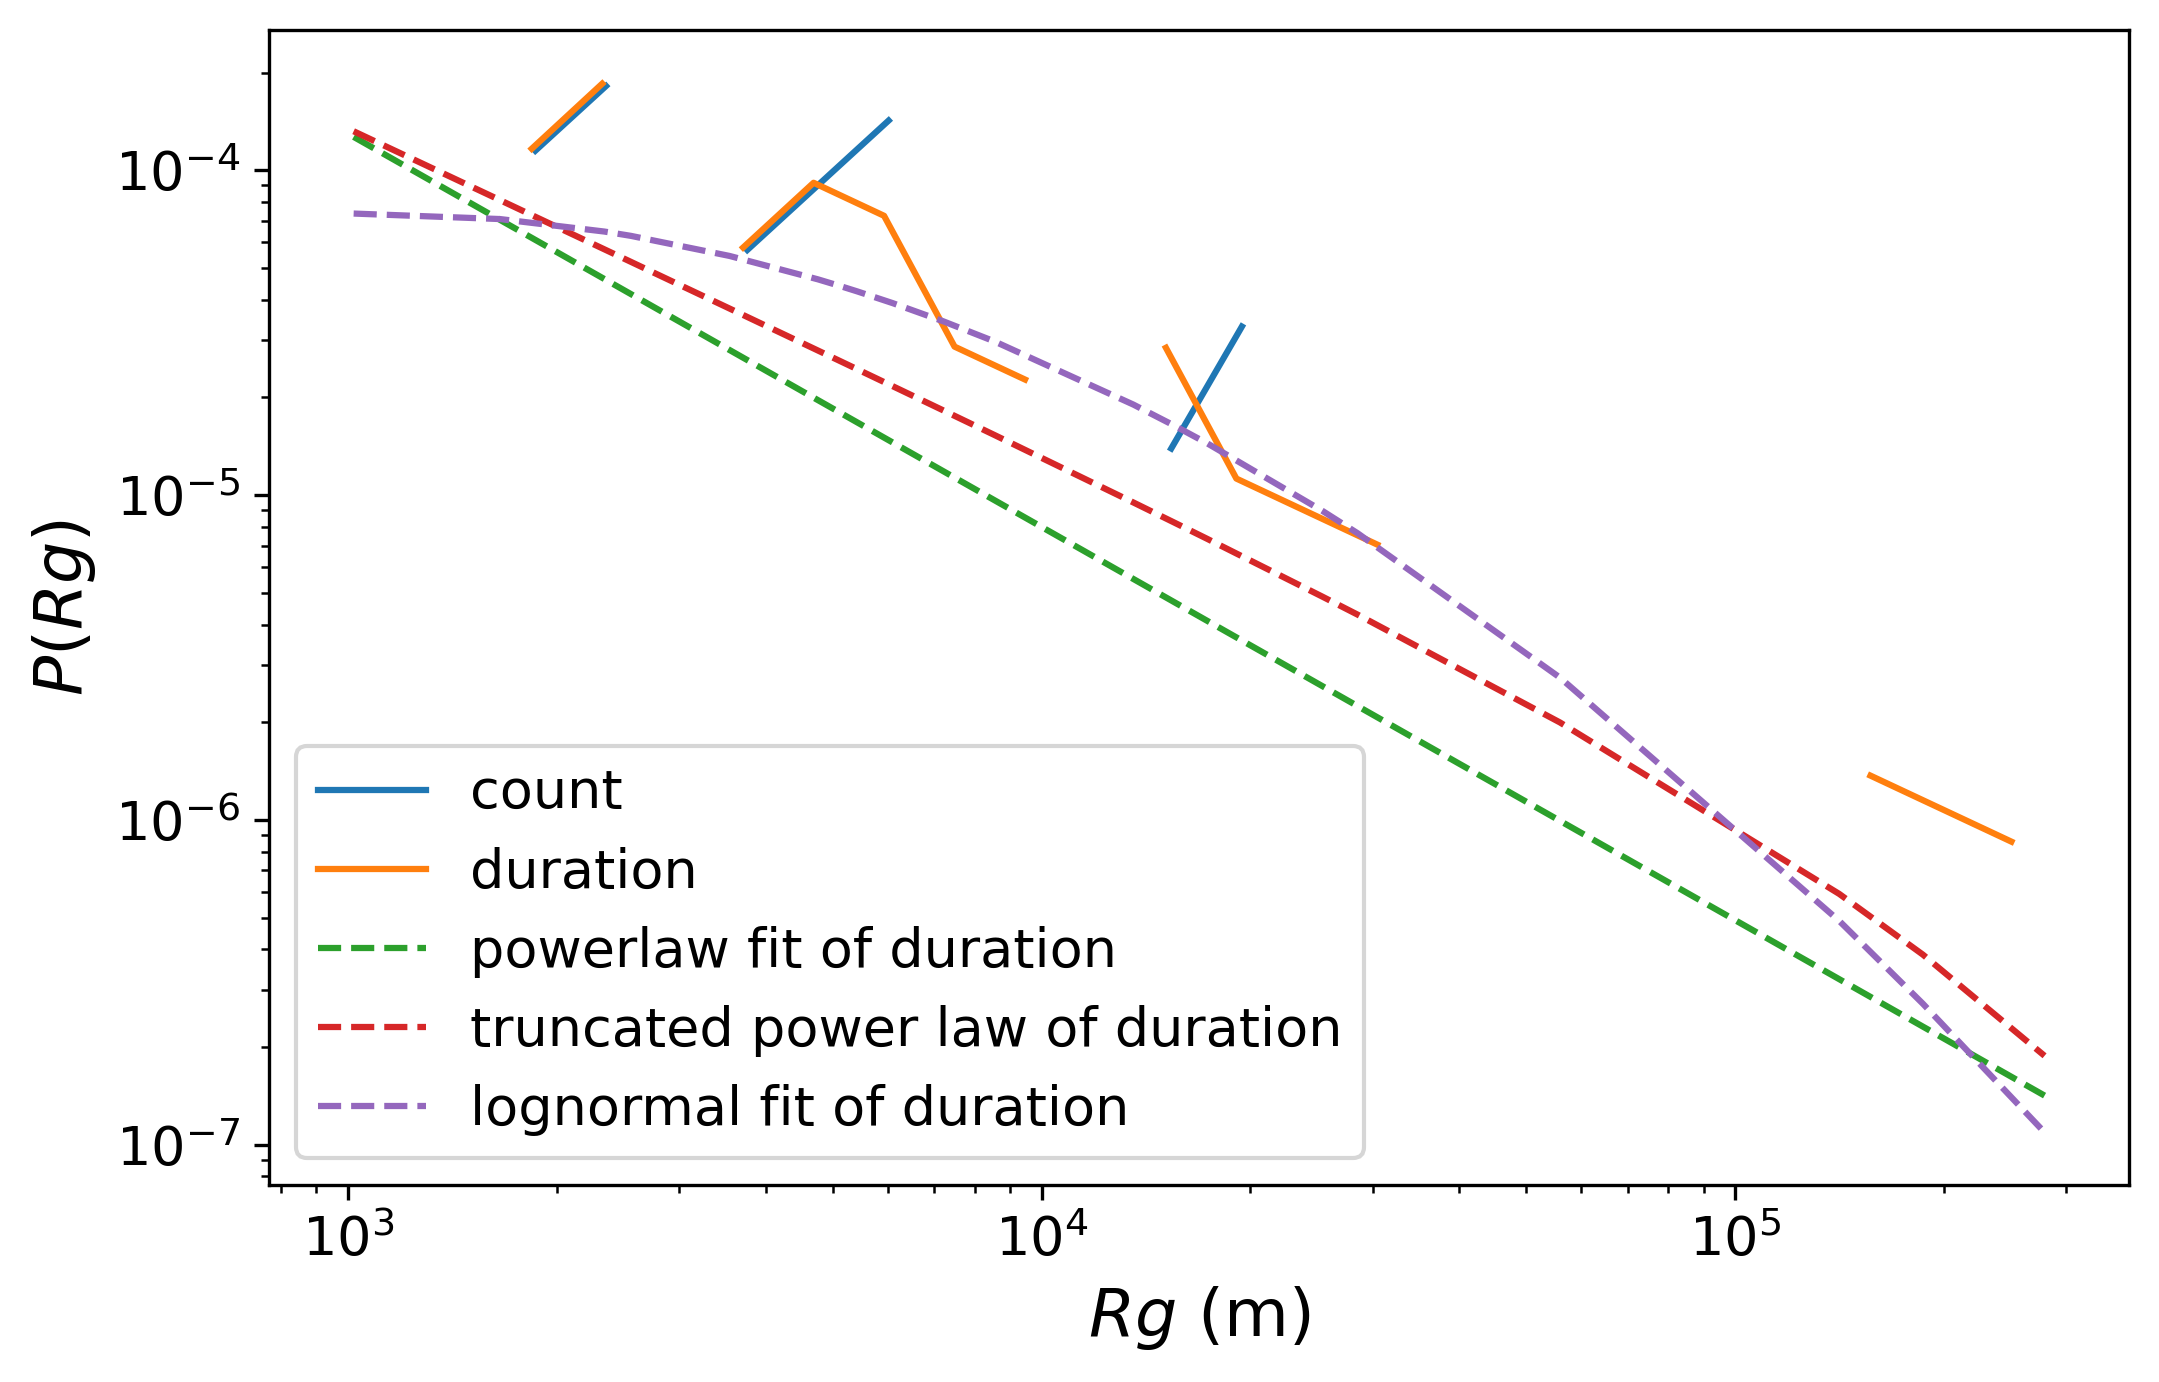

In [13]:
plt.figure(figsize=(8, 5))

# fit power law
fit = powerlaw.Fit(rg_duration, xmin=100)

# plotting
# the original data distribution
powerlaw.plot_pdf(rg_count, label="count")
powerlaw.plot_pdf(rg_duration, label="duration")

# the fitting distributions
fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit of duration")
fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law of duration")
fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit of duration")

# other plotting parameters
plt.legend(prop={"size": 13})
plt.xlabel("$Rg$ (m)", fontsize=16)
plt.ylabel("$P(Rg)$", fontsize=16)

plt.show()
